In [1]:
from accretion_utils import *
import astropy.units as u
import astropy.constants as const

# Basic modules
import numpy as np
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm


%matplotlib inline

/Users/schanlar/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def edd_limit(m):
    m = u.Quantity(m, u.Msun)
    return 1.5 * 1e-8 * (m/(1.3 * u.Msun))

def ns_radius_trans(ns_mass):
    """
    Args:
    -----
    ns_mass  : Mass of neutron star; unit [Msun]

    Return:
    -------
    Neutron star radius; unit [km]
    """
    ns_mass = u.Quantity(ns_mass, u.Msun).decompose()
    return (
        1.372631822399999990e01
        + ((ns_mass / u.Msun) - 1.402221574999999998e00) * 9.047860488123854
    ) * u.km

## Load full data and truncate at PT

In [3]:
df1 = pd.read_csv("model_m2.csv")

In [4]:
mapper = {
    "age [yr]" : "age",
    "donor_star_mass [Msun]" : "don_mass",
    "donor_star_radius [Rsun]" : "don_radius",
    "mass_transfer_rate [Msun/yr]" : "mdot_transfer",
    "mass_accretion_rate [Msun/yr]" : "mdot",
    "neutron_star_mass [Msun]" : "ns_mass",
    "neutron_star_radius [km]" : "ns_radius",
    "neutron_star_angular_momentum [Msun^2 / (c * G)]" : "ns_ang_mom",
    "neutron_star_spin_frequency [Hz]" : "ns_fspin",
    "neutron_star_spin_equilibrium_frequency [Hz]" : "ns_eq_fspin",
    "neutron_star_torque [kg * m^2 / s^2]" : "ns_torque",
    "neutron_star_magnetic_radius [km]" : "ns_r_mag",
    "neutron_star_corotation_radius [km]" : "ns_r_cor",
    "neutron_star_light_cylinder_radius [km]" : "ns_r_lc",
    "binary_separation [Rsun]" : "binary_separation",
    "orbital_period [days]" : "orbital_period"
}

In [5]:
df1.rename(columns=mapper, inplace=True)

In [6]:
df1.head(2)

,age,don_mass,don_radius,mdot_transfer,mdot,ns_mass,ns_radius,ns_ang_mom,ns_fspin,ns_eq_fspin,ns_torque,ns_r_mag,ns_r_cor,ns_r_lc,binary_separation,orbital_period
0,100000.0,1.0,0.897205,1.000000e-99,1.000000e-99,1.2,13.516911,0.000000e+00,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343237,146596.873610,21.887071,8.000000
1,220000.0,1.0,0.897208,1.000000e-99,1.000000e-99,1.2,13.516911,-5.552488e-15,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343237,146596.873583,21.887071,7.999999


In [7]:
# Transition index for Model M2
pt_idx_case2 = 36130
pt_idx_case3 = 25716

# Mass defect
delta_m = 0.01

## Conservation of angular momentum and magnetic flux for model M2

In [8]:
B_pre_trans = 1e8 * u.gauss
J_at_trans = df1["ns_ang_mom"][pt_idx_case2]

M_post = (df1["ns_mass"][pt_idx_case2] - delta_m) * u.Msun
R_post = 13.68 * u.km

In [9]:
fspin_post = (
    df1["ns_fspin"][pt_idx_case2]
    * (df1["ns_mass"][pt_idx_case2] / M_post.value)
    * ((df1["ns_radius"][pt_idx_case2] / R_post.value)**2)
) * u.Hz

# Spin frequency immediately following PT due to conservation of angular momentum
fspin_post

<Quantity 732.64043091 Hz>

In [10]:
B_post = B_pre_trans * ((df1["ns_radius"][pt_idx_case2] / R_post.value)**2)

# Surface magnetic field immediately following PT due to conservation of magnetic flux
B_post

<Quantity 1.14073821e+08 G>

## Calculate post-transition quantities for model M2

In [11]:
# Import tabulated data

ACB5file = np.genfromtxt('data/M_R_J_merged_ACB5_quark.dat')

mass_tab = ACB5file[:,0] # value given in M_sol
radius_tab = ACB5file[:,1] # value given in km
angular_momentum_tab = ACB5file[:,2] # value given in G M_sun^2 / c
spin_frequency_tab = ACB5file[:,3] # value given in Hz


# Interpolate relation between mass, radius, angular_momentum and angular velocity for ACB5

# Interpolation functions
radius_ip = interpolate.Rbf(mass_tab,
                            angular_momentum_tab,
                            radius_tab,
                            function='linear'
                           ) # use only without units (M_sun and G M_sun^2 / c)


spin_frequency_ip = interpolate.Rbf(mass_tab,
                                    angular_momentum_tab,
                                    spin_frequency_tab,
                                    function='linear'
                                   ) # use only values without units (M_sun and G M_sun^2 / c)

In [12]:
bin_data_case2 = np.genfromtxt(
    "data/md1.0_mc1.2_p8.0_z0.02_b0.5/binary_history.data", skip_header=5, names=True
)
data_case2 = np.genfromtxt(
    "data/md1.0_mc1.2_p8.0_z0.02_b0.5/history.data",
    skip_header=5,
    skip_footer=1,
    names=True,
)

In [13]:
lg_mtransfer_rate = bin_data_case2['lg_mtransfer_rate'][pt_idx_case2:]
lg_mtransfer_rate[lg_mtransfer_rate > 0] = lg_mtransfer_rate[0] #exclude some weird values
mass_transfer_rate_case2 = 10 ** lg_mtransfer_rate * (u.M_sun / u.yr)

In [14]:
age_case2 = bin_data_case2['age'][pt_idx_case2:] * u.yr

In [15]:
# Canonical neutron star properties
magnetic_field = B_post
inclination_angle = (np.pi / 2) * u.rad
zone_width = 0.02
factor_phi = 1.0
factor_xi = 1.0

# Angular momentum normalization
J0 = (const.M_sun**2) * (const.G / const.c)

In [16]:
# Define relevant arrays
angular_momentum_case2 = np.zeros_like(age_case2.value)
ns_radius_case2 = np.zeros_like(age_case2.value) * u.km
ns_fspin_case2 = np.zeros_like(age_case2.value) * u.hertz
ns_fspin_eq_case2 = np.zeros_like(age_case2.value) * u.hertz
ns_mass_case2 = np.zeros_like(age_case2.value) * u.Msun
torque_case2 = np.zeros_like(age_case2.value) * (u.kg * (u.m**2) / (u.s**2))
r_mag_case2 = np.zeros_like(age_case2.value) * u.m
r_cor_case2 = np.zeros_like(age_case2.value) * u.m
r_lc_case2 = np.zeros_like(age_case2.value) * u.m
fastness_param_case2 = np.zeros_like(age_case2.value)
mass_accretion_rate_case2 = np.zeros_like(age_case2.value) * (u.Msun / u.yr)


# The timestep
delta_t_case2 = u.Quantity(np.diff(age_case2.value), u.yr)

# Calculate radius and spin evolution for case 2
for i in range(len(age_case2)):
    if i == 0:
        ns_mass_case2[i] = M_post
        angular_momentum_case2[i] = J_at_trans
        ns_radius_case2[i] = R_post
        ns_fspin_case2[i] = fspin_post

        torque_case2[i] = accretion_torque(
            Mdot=mass_transfer_rate_case2[i],
            fspin=ns_fspin_case2[i],
            B=magnetic_field,
            M=ns_mass_case2[i],
            R=ns_radius_case2[i],
            i=inclination_angle,
            phi=factor_phi,
            xi=factor_xi,
            delta_omega=zone_width,
        )

        r_mag_case2[i] = magnetic_radius(
            Mdot=mass_transfer_rate_case2[i],
            B=magnetic_field,
            R=ns_radius_case2[i],
            M=ns_mass_case2[i],
            phi=factor_phi,
        )

        r_cor_case2[i] = corotation_radius(fspin=ns_fspin_case2[i], M=ns_mass_case2[i])
        r_lc_case2[i] = lc_radius(ns_fspin_case2[i])

        ns_fspin_eq_case2[i] = eq_spin_frequency(ns_mass_case2[i], r_mag_case2[i])

        fastness_param_case2[i] = fastness_parameter(r_mag_case2[i].to(u.m), r_cor_case2[i].to(u.m))
        
        # Initialization of mass acrretion rate (capped by Eddington limit)
        edd_accretion_limit_case2 = edd_limit(ns_mass_case2[i])
        if mass_transfer_rate_case2[i].value > edd_accretion_limit_case2.value:
            mass_accretion_rate_case2.value[i] = edd_accretion_limit_case2.value
        else:
            mass_accretion_rate_case2[i] = mass_transfer_rate_case2[i]
    
    else:
        # angular_momentum[i] = angular_momentum[i-1] + (torque[i-1]*time_step[i-1])
        
        if mass_transfer_rate_case2[i].value > edd_accretion_limit_case2.value:
            mass_accretion_rate_case2.value[i] = edd_accretion_limit_case2.value
        else:
            mass_accretion_rate_case2[i] = mass_transfer_rate_case2[i]

        if fastness_param_case2[i - 1] <= 1:
            ns_mass_case2[i] = ns_mass_case2[i - 1] + (
                1.0 * mass_transfer_rate_case2[i - 1] * delta_t_case2[i - 1]
            )
        else:
            ns_mass_case2[i] = ns_mass_case2[i - 1]

        angular_momentum_case2[i] = angular_momentum_case2[i - 1] + (
            (torque_case2[i - 1] * delta_t_case2[i - 1]) / J0
        )
        ns_radius_case2[i] = (
            radius_ip(ns_mass_case2[i].value, angular_momentum_case2[i]) * u.km
        )
        ns_fspin_case2[i] = (
            spin_frequency_ip(ns_mass_case2[i].value, angular_momentum_case2[i])
            * u.hertz
        )

        torque_case2[i] = accretion_torque(
            Mdot=mass_transfer_rate_case2[i],
            fspin=ns_fspin_case2[i],
            B=magnetic_field,
            M=ns_mass_case2[i],
            R=ns_radius_case2[i],
            i=inclination_angle,
            phi=factor_phi,
            xi=factor_xi,
            delta_omega=zone_width,
        )

        r_mag_case2[i] = magnetic_radius(
            Mdot=mass_transfer_rate_case2[i],
            B=magnetic_field,
            R=ns_radius_case2[i],
            M=ns_mass_case2[i],
            phi=factor_phi,
        )

        r_cor_case2[i] = corotation_radius(fspin=ns_fspin_case2[i], M=ns_mass_case2[i])
        r_lc_case2[i] = lc_radius(ns_fspin_case2[i])

        ns_fspin_eq_case2[i] = eq_spin_frequency(ns_mass_case2[i], r_mag_case2[i])

        fastness_param_case2[i] = fastness_parameter(
            r_mag_case2[i].to(u.m), r_cor_case2[i].to(u.m)
        )

In [17]:
data_case2 = {
    "age [yr]" : age_case2.value,
    "donor_star_mass [Msun]" : bin_data_case2["star_1_mass"][pt_idx_case2:],
    "donor_star_radius [Rsun]" : bin_data_case2["star_1_radius"][pt_idx_case2:],
    "mass_transfer_rate [Msun/yr]" : mass_transfer_rate_case2.value,
    "mass_accretion_rate [Msun/yr]" : mass_accretion_rate_case2.value,
    "neutron_star_mass [Msun]" : ns_mass_case2.value,
    "neutron_star_radius [km]" : ns_radius_case2.value,
    "neutron_star_angular_momentum [Msun^2 / (c * G)]" : angular_momentum_case2,
    "neutron_star_spin_frequency [Hz]" : ns_fspin_case2.value,
    "neutron_star_spin_equilibrium_frequency [Hz]" : ns_fspin_eq_case2,
    "neutron_star_torque [kg * m^2 / s^2]" : torque_case2.value,
    "neutron_star_magnetic_radius [km]" : r_mag_case2.to(u.km).value,
    "neutron_star_corotation_radius [km]" : r_cor_case2.to(u.km).value,
    "neutron_star_light_cylinder_radius [km]" : r_lc_case2.to(u.km).value,
    "binary_separation [Rsun]" : bin_data_case2["binary_separation"][pt_idx_case2:],
    "orbital_period [days]" : bin_data_case2["period_days"][pt_idx_case2:],
}

df2 = pd.DataFrame(data_case2)
df2.rename(columns=mapper, inplace=True)
df2

,age,don_mass,don_radius,mdot_transfer,mdot,ns_mass,ns_radius,ns_ang_mom,ns_fspin,ns_eq_fspin,ns_torque,ns_r_mag,ns_r_cor,ns_r_lc,binary_separation,orbital_period
0,1.234644e+10,0.364481,16.789500,4.143052e-09,4.143052e-09,1.490003,13.680000,0.321839,732.640431,6.743686e+02,-6.539579e+26,2.224922e+01,21.053248,65.125332,65.542514,45.228652
1,1.234644e+10,0.364461,16.790046,4.080193e-09,4.080193e-09,1.490003,13.866229,0.321728,600.754129,6.470706e+02,6.193452e+26,2.287065e+01,24.031554,79.422594,65.548189,45.234663
2,1.234645e+10,0.364442,16.790989,4.080193e-09,4.080193e-09,1.490022,13.866862,0.321829,600.917618,6.470004e+02,6.193245e+26,2.287240e+01,24.027295,79.400986,65.553669,45.240467
3,1.234645e+10,0.364419,16.791446,4.080193e-09,4.080193e-09,1.490044,13.867621,0.321951,601.113731,6.469162e+02,6.192980e+26,2.287450e+01,24.022188,79.375082,65.560270,45.247459
4,1.234646e+10,0.364398,16.792703,4.080193e-09,4.080193e-09,1.490064,13.868302,0.322060,601.289583,6.468407e+02,6.192725e+26,2.287638e+01,24.017612,79.351868,65.566164,45.253704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9106,1.856230e+10,0.298500,0.020572,1.000000e-99,1.000000e-99,1.512184,12.460049,0.104687,181.914792,1.264155e-36,-1.799206e+23,1.470682e+27,53.555841,262.284617,89.110322,72.462703
9107,1.859238e+10,0.298500,0.020563,1.000000e-99,1.000000e-99,1.512184,12.459731,0.104493,181.571253,1.264238e-36,-1.788758e+23,1.470617e+27,53.623373,262.780869,89.110322,72.462703
9108,1.862237e+10,0.298500,0.020555,1.000000e-99,1.000000e-99,1.512184,12.459416,0.104301,181.230855,1.264320e-36,-1.778446e+23,1.470554e+27,53.690497,263.274439,89.110322,72.462702
9109,1.865226e+10,0.298500,0.020546,1.000000e-99,1.000000e-99,1.512184,12.459105,0.104110,180.893613,1.264401e-36,-1.768271e+23,1.470491e+27,53.757207,263.765265,89.110322,72.462702


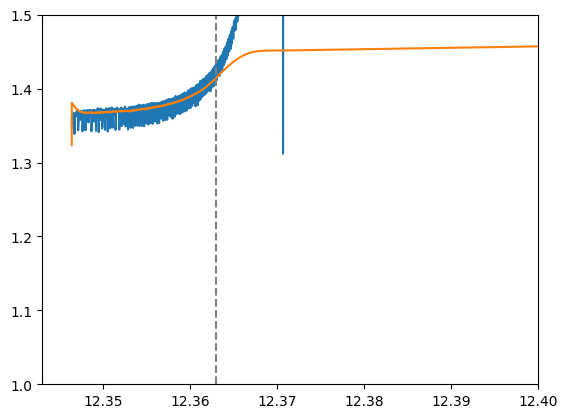

In [18]:
plt.plot(df2["age"]/1e9, np.log10(df2["ns_r_mag"]))
plt.plot(df2["age"]/1e9, np.log10(df2["ns_r_cor"]))

plt.xlim([12.343,12.4])
plt.ylim([1,1.5])

plt.axvline(12.363, ls='--', c='gray')

Text(0, 0.5, 'Fastness parameter')

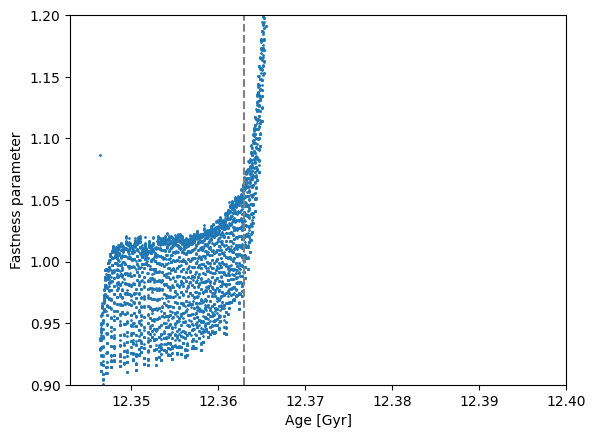

In [19]:
plt.scatter(df2["age"]/1e9, fastness_param_case2, s=1)

plt.ylim([0.9, 1.2])
plt.xlim([12.343,12.4])

plt.axvline(12.363, ls='--', c='gray')

plt.xlabel("Age [Gyr]")
plt.ylabel("Fastness parameter")

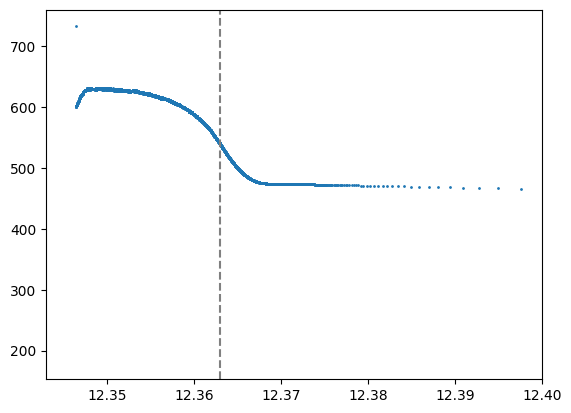

In [20]:
plt.scatter(df2["age"]/1e9, df2["ns_fspin"], s=1)

# plt.ylim([0.9, 1.2])
plt.xlim([12.343,12.4])

plt.axvline(12.363, ls='--', c='gray')

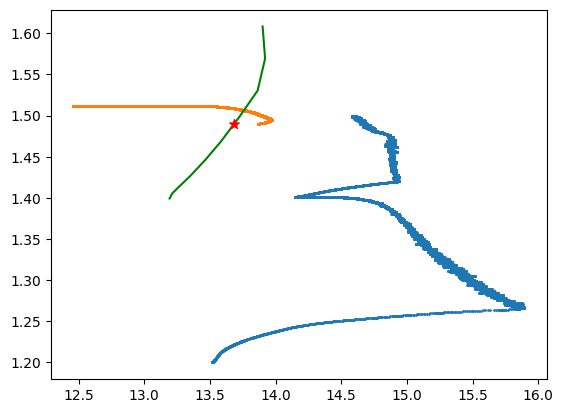

In [21]:
plt.scatter(df1['ns_radius'][:pt_idx_case2], df1['ns_mass'][:pt_idx_case2], s=1)
plt.scatter(df2['ns_radius'], df2['ns_mass'], s=1)

plt.scatter(13.68, 1.5-0.01, marker='*', s=50, c='r', zorder=10)

# Corresponding baryonic mass
R_bar = [13.193, 13.213, 13.265, 13.346, 13.466, 13.586, 13.720, 13.863, 13.920, 13.901]
M_bar = [1.3992, 1.4054, 1.4136, 1.4259, 1.4463, 1.4689, 1.4975, 1.5303, 1.5693, 1.6082]
plt.plot(R_bar, M_bar, c='g')

Following the PT, and for the next ~ 19 Myr, model M2 goes through periodic episodes of mass accretion.

## Load data for model M3

In [22]:
df3 = pd.read_csv("model_m3.csv")
df3.rename(columns=mapper, inplace=True)
df3.head(2)

,age,don_mass,don_radius,mdot_transfer,mdot,ns_mass,ns_radius,ns_ang_mom,ns_fspin,ns_eq_fspin,ns_torque,ns_r_mag,ns_r_cor,ns_r_lc,binary_separation,orbital_period
0,100000.0,1.0,0.897189,1.000000e-99,1.000000e-99,1.2,13.516911,0.000000e+00,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343237,146596.873610,43.773606,22.627
1,220000.0,1.0,0.897191,1.000000e-99,1.000000e-99,1.2,13.516911,-5.552488e-15,0.325474,9.731192e-37,-1.290623e+15,1.621065e+27,3364.343237,146596.873583,43.773606,22.627


## Conservation of angular momentum and magnetic flux for model M3

In [23]:
# B_pre_trans = 1e8 * u.gauss
J_at_trans_case3 = df3["ns_ang_mom"][pt_idx_case3]

M_post_case3 = (df3["ns_mass"][pt_idx_case3] - delta_m) * u.Msun
R_post_case3 = 13.89 * u.km

In [24]:
fspin_post_case3 = (
    df3["ns_fspin"][pt_idx_case3]
    * (df3["ns_mass"][pt_idx_case3] / M_post_case3.value)
    * ((df3["ns_radius"][pt_idx_case3] / R_post_case3.value)**2)
) * u.Hz

# Spin frequency immediately following PT due to conservation of angular momentum
fspin_post_case3

<Quantity 994.54738874 Hz>

In [25]:
B_post_case3 = B_pre_trans * ((df3["ns_radius"][pt_idx_case3] / R_post_case3.value)**2)

# Surface magnetic field immediately following PT due to conservation of magnetic flux
B_post_case3

<Quantity 1.19145524e+08 G>

In [26]:
bin_data_case3 = np.genfromtxt(
    "data/md1.0_mc1.2_p22.627_z0.02_b0.5/binary_history.data", skip_header=5, names=True
)
data_case3 = np.genfromtxt(
    "data/md1.0_mc1.2_p22.627_z0.02_b0.5/history.data",
    skip_header=5,
    skip_footer=1,
    names=True,
)

In [27]:
lg_mtransfer_rate = bin_data_case3['lg_mtransfer_rate'][pt_idx_case3:]
lg_mtransfer_rate[lg_mtransfer_rate > 0] = lg_mtransfer_rate[0] #exclude some weird values
mass_transfer_rate_case3 = 10 ** lg_mtransfer_rate * (u.M_sun / u.yr)

In [28]:
age_case3 = bin_data_case3['age'][pt_idx_case3:] * u.yr

In [29]:
# Canonical neutron star properties
magnetic_field = B_post_case3
inclination_angle = (np.pi / 2) * u.rad
zone_width = 0.02
factor_phi = 1.0
factor_xi = 1.0

# Angular momentum normalization
J0 = (const.M_sun**2) * (const.G / const.c)

In [30]:
# Define relevant arrays
angular_momentum_case3 = np.zeros_like(age_case3.value)
ns_radius_case3 = np.zeros_like(age_case3.value) * u.km
ns_fspin_case3 = np.zeros_like(age_case3.value) * u.hertz
ns_fspin_eq_case3 = np.zeros_like(age_case3.value) * u.hertz
ns_mass_case3 = np.zeros_like(age_case3.value) * u.Msun
torque_case3 = np.zeros_like(age_case3.value) * (u.kg * (u.m**2) / (u.s**2))
r_mag_case3 = np.zeros_like(age_case3.value) * u.m
r_cor_case3 = np.zeros_like(age_case3.value) * u.m
r_lc_case3 = np.zeros_like(age_case3.value) * u.m
fastness_param_case3 = np.zeros_like(age_case3.value)
mass_accretion_rate_case3 = np.zeros_like(age_case3.value) * (u.Msun / u.yr)


# The timestep
delta_t_case3 = u.Quantity(np.diff(age_case3.value), u.yr)

# Calculate radius and spin evolution for case 2
for i in range(len(age_case3)):
    if i == 0:
        ns_mass_case3[i] = M_post_case3
        angular_momentum_case3[i] = J_at_trans_case3
        ns_radius_case3[i] = R_post_case3
        ns_fspin_case3[i] = fspin_post_case3

        torque_case3[i] = accretion_torque(
            Mdot=mass_transfer_rate_case3[i],
            fspin=ns_fspin_case3[i],
            B=magnetic_field,
            M=ns_mass_case3[i],
            R=ns_radius_case3[i],
            i=inclination_angle,
            phi=factor_phi,
            xi=factor_xi,
            delta_omega=zone_width,
        )

        r_mag_case3[i] = magnetic_radius(
            Mdot=mass_transfer_rate_case3[i],
            B=magnetic_field,
            R=ns_radius_case3[i],
            M=ns_mass_case3[i],
            phi=factor_phi,
        )

        r_cor_case3[i] = corotation_radius(fspin=ns_fspin_case3[i], M=ns_mass_case3[i])
        r_lc_case3[i] = lc_radius(ns_fspin_case3[i])

        ns_fspin_eq_case3[i] = eq_spin_frequency(ns_mass_case3[i], r_mag_case3[i])

        fastness_param_case3[i] = fastness_parameter(r_mag_case3[i].to(u.m), r_cor_case3[i].to(u.m))
        
        # Initialization of mass acrretion rate (capped by Eddington limit)
        edd_accretion_limit_case3 = edd_limit(ns_mass_case3[i])
        if mass_transfer_rate_case3[i].value > edd_accretion_limit_case3.value:
            mass_accretion_rate_case3.value[i] = edd_accretion_limit_case3.value
        else:
            mass_accretion_rate_case3[i] = mass_transfer_rate_case3[i]
    
    else:
        
        if mass_transfer_rate_case3[i].value > edd_accretion_limit_case3.value:
            mass_accretion_rate_case3.value[i] = edd_accretion_limit_case3.value
        else:
            mass_accretion_rate_case3[i] = mass_transfer_rate_case3[i]

        if fastness_param_case3[i - 1] <= 1:
#             ns_mass_case3[i] = ns_mass_case3[i - 1] + (
#                 1.0 * mass_transfer_rate_case3[i - 1] * delta_t_case3[i - 1]
#             )
            ns_mass_case3[i] = ns_mass_case3[i - 1]
        else:
            ns_mass_case3[i] = ns_mass_case3[i - 1]

        angular_momentum_case3[i] = angular_momentum_case3[i - 1] + (
            (torque_case3[i - 1] * delta_t_case3[i - 1]) / J0
        )
        ns_radius_case3[i] = (
            radius_ip(ns_mass_case3[i].value, angular_momentum_case3[i]) * u.km
        )
        ns_fspin_case3[i] = (
            spin_frequency_ip(ns_mass_case3[i].value, angular_momentum_case3[i])
            * u.hertz
        )

        torque_case3[i] = accretion_torque(
            Mdot=mass_transfer_rate_case3[i],
            fspin=ns_fspin_case3[i],
            B=magnetic_field,
            M=ns_mass_case3[i],
            R=ns_radius_case3[i],
            i=inclination_angle,
            phi=factor_phi,
            xi=factor_xi,
            delta_omega=zone_width,
        )

        r_mag_case3[i] = magnetic_radius(
            Mdot=mass_transfer_rate_case3[i],
            B=magnetic_field,
            R=ns_radius_case3[i],
            M=ns_mass_case3[i],
            phi=factor_phi,
        )

        r_cor_case3[i] = corotation_radius(fspin=ns_fspin_case3[i], M=ns_mass_case3[i])
        r_lc_case3[i] = lc_radius(ns_fspin_case3[i])

        ns_fspin_eq_case3[i] = eq_spin_frequency(ns_mass_case3[i], r_mag_case3[i])

        fastness_param_case3[i] = fastness_parameter(
            r_mag_case3[i].to(u.m), r_cor_case3[i].to(u.m)
        )

In [31]:
data_case3 = {
    "age [yr]" : age_case3.value,
    "donor_star_mass [Msun]" : bin_data_case3["star_1_mass"][pt_idx_case3:],
    "donor_star_radius [Rsun]" : bin_data_case3["star_1_radius"][pt_idx_case3:],
    "mass_transfer_rate [Msun/yr]" : mass_transfer_rate_case3.value,
    "mass_accretion_rate [Msun/yr]" : mass_accretion_rate_case3.value,
    "neutron_star_mass [Msun]" : ns_mass_case3.value,
    "neutron_star_radius [km]" : ns_radius_case3.value,
    "neutron_star_angular_momentum [Msun^2 / (c * G)]" : angular_momentum_case3,
    "neutron_star_spin_frequency [Hz]" : ns_fspin_case3.value,
    "neutron_star_spin_equilibrium_frequency [Hz]" : ns_fspin_eq_case3,
    "neutron_star_torque [kg * m^2 / s^2]" : torque_case3.value,
    "neutron_star_magnetic_radius [km]" : r_mag_case3.to(u.km).value,
    "neutron_star_corotation_radius [km]" : r_cor_case3.to(u.km).value,
    "neutron_star_light_cylinder_radius [km]" : r_lc_case3.to(u.km).value,
    "binary_separation [Rsun]" : bin_data_case3["binary_separation"][pt_idx_case3:],
    "orbital_period [days]" : bin_data_case3["period_days"][pt_idx_case3:],
}

df4 = pd.DataFrame(data_case3)
df4.rename(columns=mapper, inplace=True)
df4

,age,don_mass,don_radius,mdot_transfer,mdot,ns_mass,ns_radius,ns_ang_mom,ns_fspin,ns_eq_fspin,ns_torque,ns_r_mag,ns_r_cor,ns_r_lc,binary_separation,orbital_period
0,1.235913e+10,0.357792,36.063232,8.345891e-09,8.345891e-09,1.550888,13.890000,0.409504,994.547389,8.678931e+02,-1.266691e+27,1.905753e+01,17.403121,47.975041,148.812193,154.998784
1,1.235913e+10,0.357761,36.063739,8.345891e-09,8.345891e-09,1.550888,13.897486,0.409354,728.552179,8.666915e+02,1.181424e+27,1.907514e+01,21.415934,65.490782,148.831223,155.029278
2,1.235914e+10,0.357730,36.065152,8.345891e-09,8.345891e-09,1.550888,13.898773,0.409496,728.729581,8.664852e+02,1.181488e+27,1.907817e+01,21.412458,65.474838,148.850500,155.060172
3,1.235914e+10,0.357697,36.067489,8.345891e-09,8.345891e-09,1.550888,13.900159,0.409649,728.920447,8.662629e+02,1.181558e+27,1.908143e+01,21.408720,65.457694,148.871267,155.093455
4,1.235914e+10,0.357657,36.071302,8.345891e-09,8.345891e-09,1.550888,13.901824,0.409833,729.149230,8.659963e+02,1.181641e+27,1.908535e+01,21.404242,65.437156,148.896222,155.133452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4988,1.732769e+10,0.331948,0.019228,1.000000e-99,1.000000e-99,1.550888,12.295651,0.124763,208.286237,1.283157e-36,-2.720398e+23,1.468445e+27,49.348098,229.076353,164.143068,180.383402
4989,1.735203e+10,0.331948,0.019222,1.000000e-99,1.000000e-99,1.550888,12.295247,0.124525,207.878713,1.283265e-36,-2.703929e+23,1.468362e+27,49.412571,229.525432,164.143068,180.383402
4990,1.737631e+10,0.331948,0.019215,1.000000e-99,1.000000e-99,1.550888,12.294848,0.124290,207.474581,1.283372e-36,-2.687667e+23,1.468280e+27,49.476716,229.972517,164.143068,180.383402
4991,1.740054e+10,0.331948,0.019208,1.000000e-99,1.000000e-99,1.550888,12.294454,0.124056,207.073842,1.283478e-36,-2.671609e+23,1.468200e+27,49.540529,230.417570,164.143068,180.383402


(1.0, 1.5)

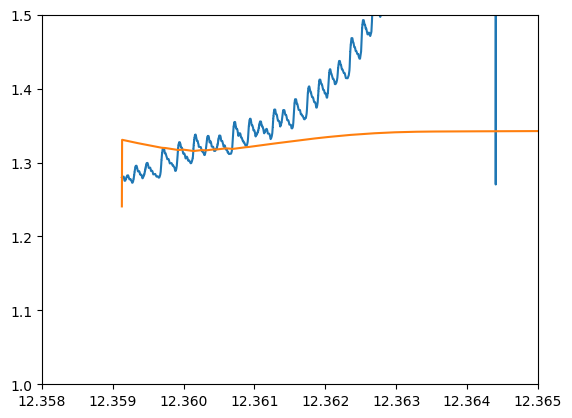

In [32]:
plt.plot(df4["age"]/1e9, np.log10(df4["ns_r_mag"]))
plt.plot(df4["age"]/1e9, np.log10(df4["ns_r_cor"]))

plt.xlim([12.358,12.365])
plt.ylim([1,1.5])


Text(0, 0.5, 'Fastness parameter')

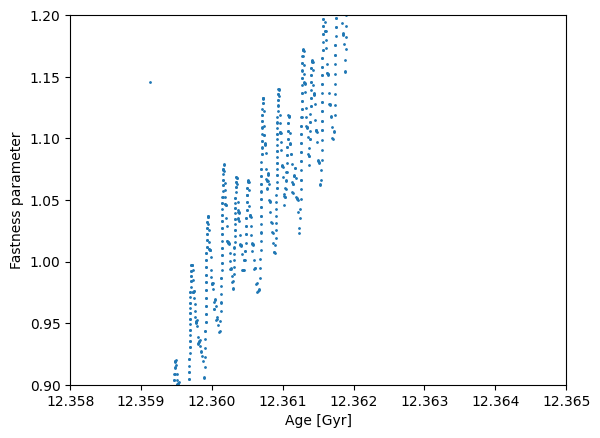

In [33]:
plt.scatter(df4["age"]/1e9, fastness_param_case3, s=1)

plt.ylim([0.9, 1.2])
plt.xlim([12.358,12.365])

plt.xlabel("Age [Gyr]")
plt.ylabel("Fastness parameter")

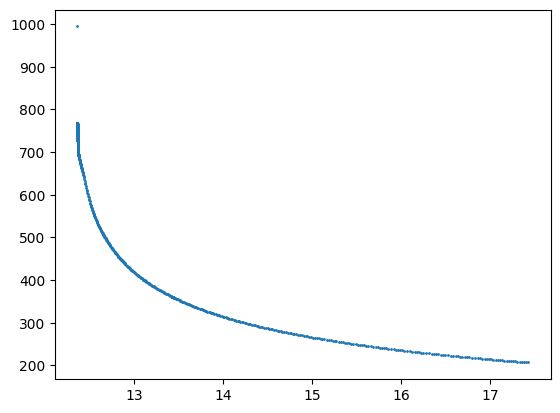

In [34]:
plt.scatter(df4["age"]/1e9, df4["ns_fspin"], s=1)

In [35]:
# plt.scatter(df1['ns_radius'][:pt_idx_case2], df1['ns_mass'][:pt_idx_case2], s=1)
# plt.scatter(df2['ns_radius'], df2['ns_mass'], s=1)

# plt.scatter(df3['ns_radius'][:pt_idx_case3], df3['ns_mass'][:pt_idx_case3], s=1)
# plt.scatter(df4['ns_radius'], df4['ns_mass'], s=1)

# plt.scatter(13.68, 1.5-0.01, marker='*', s=50, c='r', zorder=10)
# plt.scatter(13.89, 1.56-0.01, marker='*', s=50, c='r', zorder=10)

# Corresponding baryonic mass
# R_bar = [13.193, 13.213, 13.265, 13.346, 13.466, 13.586, 13.720, 13.863, 13.920, 13.901]
# M_bar = [1.3992, 1.4054, 1.4136, 1.4259, 1.4463, 1.4689, 1.4975, 1.5303, 1.5693, 1.6082]
# plt.plot(R_bar, M_bar, c='g')


In [36]:
#Import tabulated data

ACB5file = np.genfromtxt('data/M_R_J_merged_ACB5.dat')

mass_tab = ACB5file[:,0]                  # value given in M_sol
radius_tab = ACB5file[:,1]                # value given in km
angular_momentum_tab = ACB5file[:,2]      # value given in G M_sun^2 / c
spin_frequency_tab = ACB5file[:,3]        # value given in Hz

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


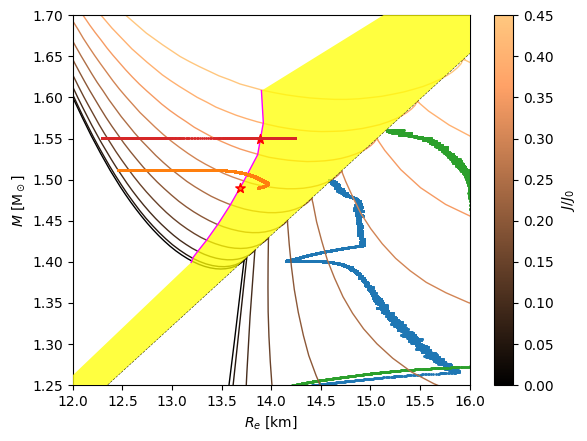

In [37]:
# Set up the colormap
norm = mcolors.Normalize(vmin=0.0, vmax=0.45)
cmap = cm.copper  # Using copper colormap

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

Js = ['0.0','0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45']

for J in Js:
    radius = radius_tab[angular_momentum_tab == np.float64(J)]
    mass = mass_tab[angular_momentum_tab == np.float64(J)]
    color = cmap(norm(np.float64(J)))

    ax.plot(radius, mass, ls="-", color=color, lw=1)

# Corresponding baryonic mass
R_bar = [13.193, 13.213, 13.265, 13.346, 13.466, 13.586, 13.720, 13.863, 13.920, 13.901]
M_bar = [1.3992, 1.4054, 1.4136, 1.4259, 1.4463, 1.4689, 1.4975, 1.5303, 1.5693, 1.6082]

ns_mass = np.linspace(0, 2, 100)
radius_dashed = ns_radius_trans(ns_mass).value

x_fill = np.concatenate([R_bar, radius_dashed[::-1]])
y_fill = np.concatenate([M_bar, ns_mass[::-1]])

# Fill the area defined by the points
plt.fill(x_fill, y_fill, "yellow", zorder=9, alpha=0.75) # "white" for paper

plt.plot(R_bar, M_bar, c="magenta", ls="-", lw=1., zorder=10)

# Add the colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$J/J_0$", rotation=90, labelpad=5)



# Setting labels, limits, and rest of the figure attributes
ax.set_xlabel(r"$R_e$ [km]")
ax.set_ylabel(r"$M$ [M$_\odot$]")
ax.set_ylim([1.25, 1.7])
ax.set_xlim([12, 16])

# ax.text(10, 2.1, r"$J_0 = G M_\odot^2 / c$", fontsize=9)

# Transition line and texts
plt.plot(
    ns_radius_trans(np.linspace(0, 2, 100)),
    np.linspace(0, 2, 100),
    ls="--",
    c="black",
    lw=0.5,
)


# ax.text(10, 0.88, "hadronic branch", rotation=21, size=6)
# ax.text(9.7, 1.05, "hybrid star branch", rotation=21, size=6)

ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=6)


plt.scatter(df1['ns_radius'][:pt_idx_case2], df1['ns_mass'][:pt_idx_case2], s=1)
plt.scatter(df2['ns_radius'], df2['ns_mass'], s=1, zorder=1000)

plt.scatter(df3['ns_radius'][:pt_idx_case3], df3['ns_mass'][:pt_idx_case3], s=1)
plt.scatter(df4['ns_radius'], df4['ns_mass'], s=1,zorder=1000)

plt.scatter(13.68, 1.5-0.01, marker='*', s=50, c='r', zorder=10)
plt.scatter(13.89, 1.56-0.01, marker='*', s=50, c='r', zorder=10)


# plt.annotate("", 
#             xy=(13.68, 
#                 df1["ns_mass"][pt_idx_case2] - 0.01
#                ), 
#             xytext=(df1["ns_radius"][pt_idx_case2], 
#                     df1["ns_mass"][pt_idx_case2]
#                    ),
#             arrowprops=dict(arrowstyle="->", 
#                             color='k', 
#                             lw=1.0, 
#                             connectionstyle="arc3,rad=0."
#                            ),
#             zorder=1000
# )

# plt.annotate("", 
#             xy=(13.89, 
#                 df3["ns_mass"][pt_idx_case3] - 0.01
#                ), 
#             xytext=(df3["ns_radius"][pt_idx_case3], 
#                     df3["ns_mass"][pt_idx_case3]
#                    ),
#             arrowprops=dict(arrowstyle="->", 
#                             color='k', 
#                             lw=1.0, 
#                             connectionstyle="arc3,rad=0."
#                            ),
#             zorder=1000
# )


plt.show()

In [43]:
model_m1 = pd.read_csv("model_m1.csv")
model_m1.rename(columns=mapper, inplace=True)

In [46]:
model_m2 = df1
model_m3 = df3

transition_idx_case2 = pt_idx_case2
transition_idx_case3 = pt_idx_case3

In [92]:
plt.style.use(["default", "science"])

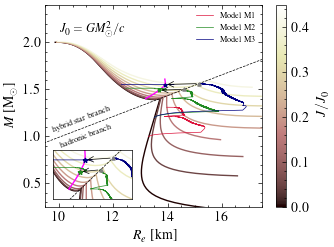

In [101]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

m2_color = 'forestgreen'
m3_color = 'navy'

# Set up the colormap
norm = mcolors.Normalize(vmin=0.0, vmax=0.45)
cmap = cm.pink  # Using copper colormap

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # You have to set the array for the ScalarMappable

for J in Js:
    radius = radius_tab[angular_momentum_tab == np.float64(J)]
    mass = mass_tab[angular_momentum_tab == np.float64(J)]
    color = cmap(norm(np.float64(J)))
    ax.plot(radius, mass, ls='-', color=color, lw=1)

# Corresponding baryonic mass
R_bar = [13.193, 13.213, 13.265, 13.346, 13.466, 13.586, 13.720, 13.863, 13.920, 13.901]
M_bar = [1.3992, 1.4054, 1.4136, 1.4259, 1.4463, 1.4689, 1.4975, 1.5303, 1.5693, 1.6082]
ax.plot(R_bar, M_bar, c='magenta', ls='-')

# Add the colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('$J/J_0$', rotation=90, labelpad=5)

# Model plots with updated colors for visibility
ax.plot(model_m1["ns_radius"], 
        model_m1["ns_mass"],  
        color='crimson',
        lw=0.5,
        label='Model M1'
)

ax.plot(model_m2["ns_radius"][:transition_idx_case2], 
        model_m2["ns_mass"][:transition_idx_case2], 
        color=m2_color,
        lw=0.5,
        label='Model M2'
)

ax.plot(model_m3["ns_radius"][:transition_idx_case3], 
        model_m3["ns_mass"][:transition_idx_case3], 
        color=m3_color,
        lw=0.5,
        label='Model M3'
)

# Enhanced markers for transition points with more visible colors and sizes
ax.scatter(
    13.68,
    model_m2["ns_mass"][transition_idx_case2] - 0.01,
    marker="*",
    c=m2_color,
    s=5,
    zorder=9
)

ax.scatter(
    13.89,
    model_m3["ns_mass"][transition_idx_case3] - 0.01,
    marker="*",
    c=m3_color,
    s=5,
    zorder=9
)

# Mark the transition point
ax.scatter(
    model_m2["ns_radius"][transition_idx_case2], 
    model_m2["ns_mass"][transition_idx_case2], 
    marker='^', 
    c='grey', 
    s=5, 
    zorder=10
)

ax.scatter(
    model_m3["ns_radius"][transition_idx_case3], 
    model_m3["ns_mass"][transition_idx_case3], 
    marker='^', 
    c='grey', 
    s=5, 
    zorder=10
)

# Improved arrow properties for better visibility
arrowprops=dict(arrowstyle="->", color='k', lw=0.5, connectionstyle="arc3,rad=0.")

ax.annotate("", xy=(13.68, model_m2["ns_mass"][transition_idx_case2] - 0.01), 
            xytext=(model_m2["ns_radius"][transition_idx_case2], model_m2["ns_mass"][transition_idx_case2]), arrowprops=arrowprops)

ax.annotate("", xy=(13.89, model_m3["ns_mass"][transition_idx_case3] - 0.01), 
            xytext=(model_m3["ns_radius"][transition_idx_case3], model_m3["ns_mass"][transition_idx_case3]), arrowprops=arrowprops)


# Setting labels, limits, and rest of the figure attributes
ax.set_xlabel(r"$R_e$ [km]")
ax.set_ylabel(r"$M$ [M$_\odot$]")
ax.set_ylim([0.25, 2.4])
ax.set_xlim([9.5, 17.5])

ax.text(10, 2.1, r"$J_0 = G M_\odot^2 / c$", fontsize=9)

# Transition line and texts
ax.plot(ns_radius_trans(np.linspace(0, 2, 100)), np.linspace(0, 2, 100), ls='--', c='black', lw=0.5)

ax.text(10, 0.88, "hadronic branch", rotation=21, size=6)
ax.text(9.7, 1.05, "hybrid star branch", rotation=21, size=6)

ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=6)


ax.plot(df2['ns_radius'], df2['ns_mass'], lw=0.5, zorder=2, c=m2_color)
ax.plot(df4['ns_radius'], df4['ns_mass'], lw=0.5 ,zorder=2, c=m3_color)

# ------------- INSET PLOT -------------

# Add the zoomed inset with manual positioning
ax_inset = inset_axes(ax, width="90%", height="80%", 
                      bbox_to_anchor=(0.005, 0.005, 0.4, 0.3), 
                      bbox_transform=ax.transAxes, loc='lower left')

for J in Js:
    radius = radius_tab[angular_momentum_tab == np.float64(J)]
    mass = mass_tab[angular_momentum_tab == np.float64(J)]
    color = cmap(norm(np.float64(J)))
    ax_inset.plot(radius, mass, ls='-', color=color, lw=1)

ax_inset.plot(R_bar, M_bar, c='magenta', ls='-')

ax_inset.plot(model_m1["ns_radius"], 
              model_m1["ns_mass"],  
              color='crimson',
              lw=0.5,
              label='Model M1'
)

ax_inset.plot(model_m2["ns_radius"][:transition_idx_case2], 
              model_m2["ns_mass"][:transition_idx_case2], 
              color=m2_color,
              lw=0.5,
              label='Model M2'
)

ax_inset.plot(model_m3["ns_radius"][:transition_idx_case3], 
              model_m3["ns_mass"][:transition_idx_case3], 
              color=m3_color,
              lw=0.5,
              label='Model M3'
)

ax_inset.scatter(13.68, model_m2["ns_mass"][transition_idx_case2] - 0.01, 
                 marker="*", c=m2_color, s=10, zorder=9)

ax_inset.scatter(13.89, model_m3["ns_mass"][transition_idx_case3] - 0.01, 
                 marker="*", c=m3_color, s=10, zorder=9)

# Annotations in the inset
ax_inset.annotate("", xy=(13.68, model_m2["ns_mass"][transition_idx_case2] - 0.01), 
                  xytext=(model_m2["ns_radius"][transition_idx_case2], model_m2["ns_mass"][transition_idx_case2]), arrowprops=arrowprops)

ax_inset.annotate("", xy=(13.89, model_m3["ns_mass"][transition_idx_case3] - 0.01), 
                  xytext=(model_m3["ns_radius"][transition_idx_case3], model_m3["ns_mass"][transition_idx_case3]), arrowprops=arrowprops)

# Transition line in the inset
ax_inset.plot(ns_radius_trans(np.linspace(0, 2, 100)), np.linspace(0, 2, 100), ls='--', c='black', lw=0.5)

# Mark the transition point in the inset
ax_inset.scatter(
    model_m2["ns_radius"][transition_idx_case2], 
    model_m2["ns_mass"][transition_idx_case2], 
    marker='^', 
    c='grey', 
    s=5, 
    zorder=10
)

ax_inset.scatter(
    model_m3["ns_radius"][transition_idx_case3], 
    model_m3["ns_mass"][transition_idx_case3], 
    marker='^', 
    c='grey', 
    s=5, 
    zorder=10
)

# Setting limits and removing ticks in the inset
ax_inset.set_xlim(12.5, 16)
ax_inset.set_ylim(1.35, 1.6)
ax_inset.set_xticks([])
ax_inset.set_yticks([])


ax_inset.plot(df2['ns_radius'], df2['ns_mass'], lw=0.5, zorder=2, c=m2_color)
ax_inset.plot(df4['ns_radius'], df4['ns_mass'], lw=0.5, zorder=2, c=m3_color)



plt.show()
# plt.savefig("m_vs_r.png", bbox_inches='tight', dpi=300)

In [109]:
df1.ns_mass.to_numpy()[pt_idx_case2]

1.500003116765276

In [108]:
df1.ns_mass.to_numpy()[-1]

1.5224343693329925

In [110]:
df2.ns_mass.to_numpy()[-1]

1.5121840629472418

In [113]:
# df2.to_csv("data/posttrans_evolution_m2.csv", index=False)
# df4.to_csv("data/posttrans_evolution_m3.csv", index=False)

In [116]:
xi_case2 = (14.61 - df2.ns_radius.to_numpy()[-1])/14.61
xi_case3 = (15.16 - df4.ns_radius.to_numpy()[-1])/15.16

print(f"xi2 = {xi_case2*100:.1f}%, xi3 = {xi_case3*100:.1f}%")

xi2 = 14.7%, xi3 = 18.9%


In [119]:
df4["ns_ang_mom"].to_numpy()[-1]

0.12382487744228943